In [170]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import math

In [171]:
stock_name='BABA'

In [172]:
# 读取数据，pd.read_csv默认生成DataFrame对象，需将其转换成Series对象
df_ori = pd.read_csv('../../dataset/5year/'+stock_name+'-5year.csv',header=0)
df_ori.index = pd.to_datetime(df_ori['Date'])  # 将字符串索引转换成时间索引
#df=df_ori.asfreq(freq='3d',method='ffill')
df_ori.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2014-09-19,2014-09-19,92.699997,99.699997,89.949997,93.889999,93.889999,271879400
2014-09-22,2014-09-22,92.699997,92.949997,89.500000,89.889999,89.889999,66657800
2014-09-23,2014-09-23,88.940002,90.480003,86.620003,87.169998,87.169998,39009800
2014-09-24,2014-09-24,88.470001,90.570000,87.220001,90.570000,90.570000,32088000
2014-09-25,2014-09-25,91.089996,91.500000,88.500000,88.919998,88.919998,28598000


In [173]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
sc_close=sc.fit_transform(df_ori['Close'].values.reshape(-1,1))

In [174]:
def data_to_x_y(data,n_in_steps,n_out_steps):
    X_data,y_data=[],[]
    for i in range(0,data.shape[0]-n_in_steps-n_out_steps):
        X_data.append(data[i:i+n_in_steps])
        y_data.append(data[i+n_in_steps+n_out_steps-1])
    X_data=np.array(X_data)
    y_data=np.array(y_data)
    #X_data=X_data.reshape(X_train.shape[0],X_train.shape[1],1)
    #y_data=y_data.reshape(y_train.shape[0],1)
    return X_data,y_data
def train_test_split(X_data,y_data,train_percentage):
    n_train_intervals = math.ceil(X_data.shape[0] * train_percentage) 
    X_train,y_train=X_data[:n_train_intervals],y_data[:n_train_intervals]
    X_test,y_test=X_data[n_train_intervals:],y_data[n_train_intervals:]
    return X_train,y_train,X_test,y_test

In [175]:
timestep=10
outstep=15

In [176]:
X_data,y_data=data_to_x_y(sc_close,timestep,outstep)
X_train,y_train,X_test,y_test=train_test_split(X_data,y_data,0.7)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1])
y_train=y_train.reshape(y_train.shape[0])
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1])
y_test=y_test.reshape(y_test.shape[0])
print(X_train.shape)
print(y_train.shape)

(808, 10)
(808,)


In [177]:
#SVR Model
svr_rbf = SVR(kernel='rbf', C=10,gamma=5)
rbf_fit = svr_rbf.fit(X_train, y_train)

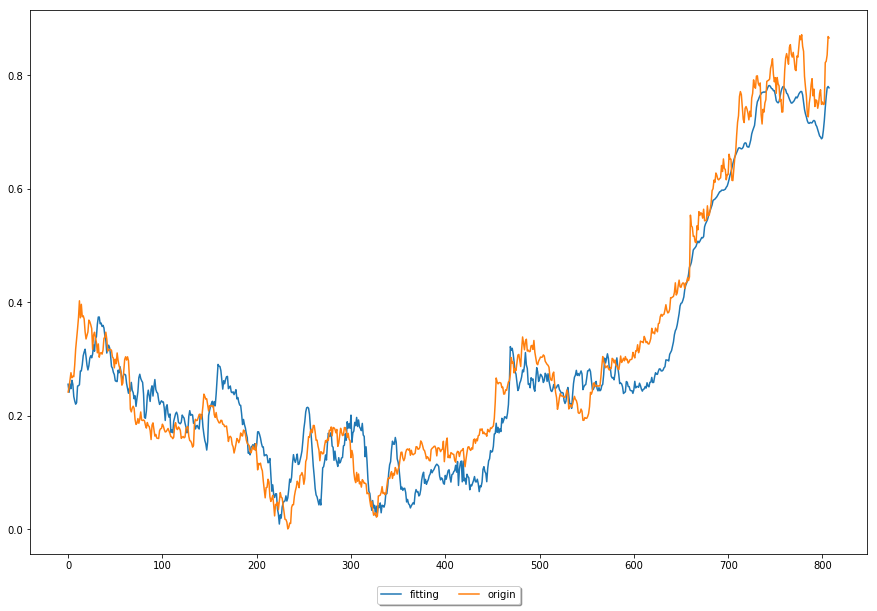

In [178]:
#训练集拟合
ypre=rbf_fit.predict(X_train)
plt.figure(figsize=(15,10))
plt.plot(ypre,label='fitting')
plt.plot(y_train,label='origin')
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.show()

In [179]:
def generate_test(data,n_in_steps,n_out_steps):
    X_test=[]
    for i in range(data.shape[0]-n_out_steps,data.shape[0]):
            X_test.append(data[i-n_in_steps:i])
    X_test=np.array(X_test)
    return X_test

In [180]:
yhat=rbf_fit.predict(X_test)

In [181]:
# print(yhat)
print(X_test.shape)

(345, 10)


In [182]:
inv_yhat=sc.inverse_transform(yhat.reshape(-1,1))
inv_ytest=sc.inverse_transform(y_test.reshape(-1,1))

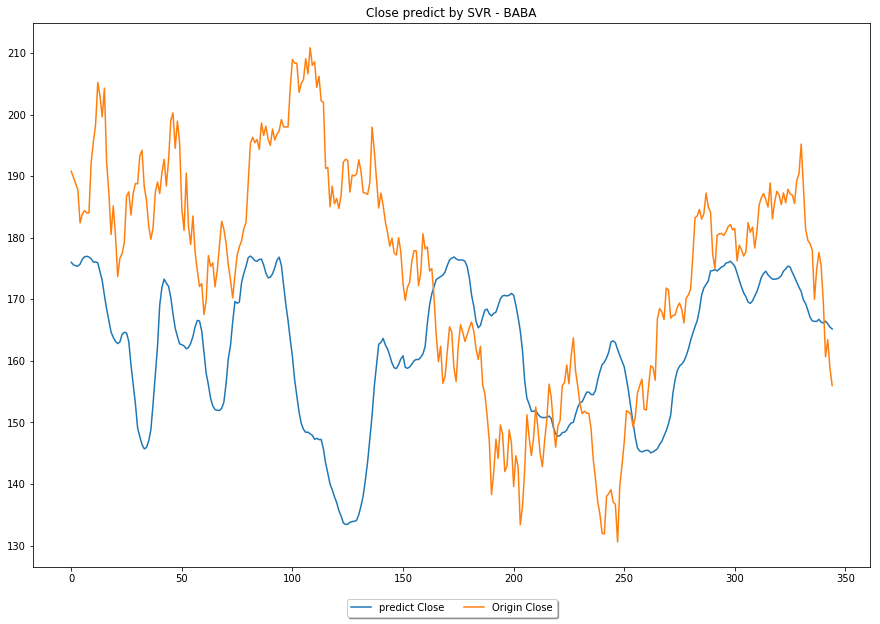

In [183]:
plt.figure(figsize=(15,10))
plt.plot(inv_yhat,label = 'predict Close')
plt.plot(inv_ytest,label = 'Origin Close')
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('Close predict by SVR - '+stock_name)
plt.savefig('../../image/SVR-15/'+stock_name+'-15.png')
plt.show()

In [184]:
#误差统计
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

avg=np.mean(inv_ytest)

rmse=math.sqrt(mean_squared_error(inv_yhat, inv_ytest))
mae=mean_absolute_error(inv_yhat, inv_ytest)                     
rmse_error_percentage = rmse/avg
mae_error_percentage = mae/avg
print('TEST RMSE: %.4f' % rmse)
print('TEST MAE: %.4f'% mae)
print("Test RMSE Error Percentage: %.2f/100.00" % (rmse_error_percentage * 100))
print("Test MAE Error Percentage: %.2f/100.00" % (mae_error_percentage * 100))

TEST RMSE: 24.3722
TEST MAE: 19.3928
Test RMSE Error Percentage: 13.93/100.00
Test MAE Error Percentage: 11.09/100.00
